(example_1)=
# Example 1: Bayesian filtering of cardiac volatility

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ComputationalPsychiatry/pyhgf/blob/master/docs/source/notebooks/Example_1_Heart_rate_variability.ipynb)

In [1]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark systole

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
from pyhgf.response import total_gaussian_surprise

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The nodalized version of the Hierarchical Gaussian Filter that is implemented in [pyhgf](https://github.com/ComputationalPsychiatry/pyhgf) opens the possibility to create filters with multiple inputs. Here, we illustrate how we can use this feature to create an agent that is filtering their physiological signals in real-time. We use a two-level Hierarchical Gaussian Filter to predict the dynamics of the instantaneous heart rate (the RR interval measured at each heartbeat). We then extract the trajectory of surprise at each predictive node to relate it with the cognitive task performed by the participant while the signal is being recorded.

## Loading physiological recording
We use a RR time series included in [Systole](https://legrandnico.github.io/systole/#) as an example.

In [3]:
rr_s = pd.read_csv("https://raw.githubusercontent.com/LegrandNico/systole/refs/heads/main/src/systole/datasets/rr.txt").rr.to_numpy() / 1000

## Model

```{note}
Here we use the total Gaussian surprise ({py:func}`pyhgf.response.total_gaussian_surprise`) as a response function. This response function deviates from the default behaviour for the continuous HGF in that it returns the sum of the surprise for all the probabilistic nodes in the network, whereas the default ({py:func}`pyhgf.response.first_level_gaussian_surprise`) only computes the surprise at the first level (i.e. the value parent of the continuous input node). We explicitly specify this parameter here to indicate that we want our model to minimise its prediction errors over all variables, and not only at the observation level. In this case, however, the results are expected to be very similar between the two methods.
```

In [4]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=rr_s[np.newaxis, :],
    response_function=total_gaussian_surprise,
)

In [5]:
with pm.Model() as three_level_hgf:

    # omegas priors
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -2.0, 2.0)

    # HGF distribution
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_1=-4.0, tonic_volatility_2=tonic_volatility_2))

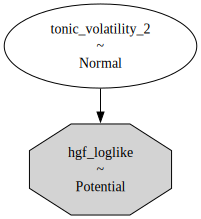

In [6]:
pm.model_to_graphviz(three_level_hgf)

In [7]:
with three_level_hgf:
    idata = pm.sample(chains=2, cores=1)

Initializing NUTS using jitter+adapt_diag...


Sequential sampling (2 chains in 1 job)


NUTS: [tonic_volatility_2]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


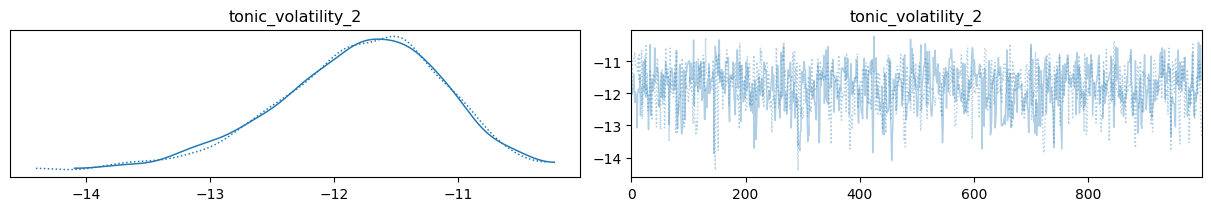

In [8]:
az.plot_trace(idata);

In [9]:
# retrieve the best fir for omega_2
tonic_volatility_2 = az.summary(idata)["mean"]["tonic_volatility_2"]

In [10]:
hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mean={"1": rr_s[0], "2": -4.0},
    initial_precision={"1": 1e4, "2": 1e1},
    tonic_volatility={"1": -4.0, "2": tonic_volatility_2},
    tonic_drift={"1": 0.0, "2": 0.0},
    volatility_coupling={"1": 1.0}).input_data(input_data=rr_s)

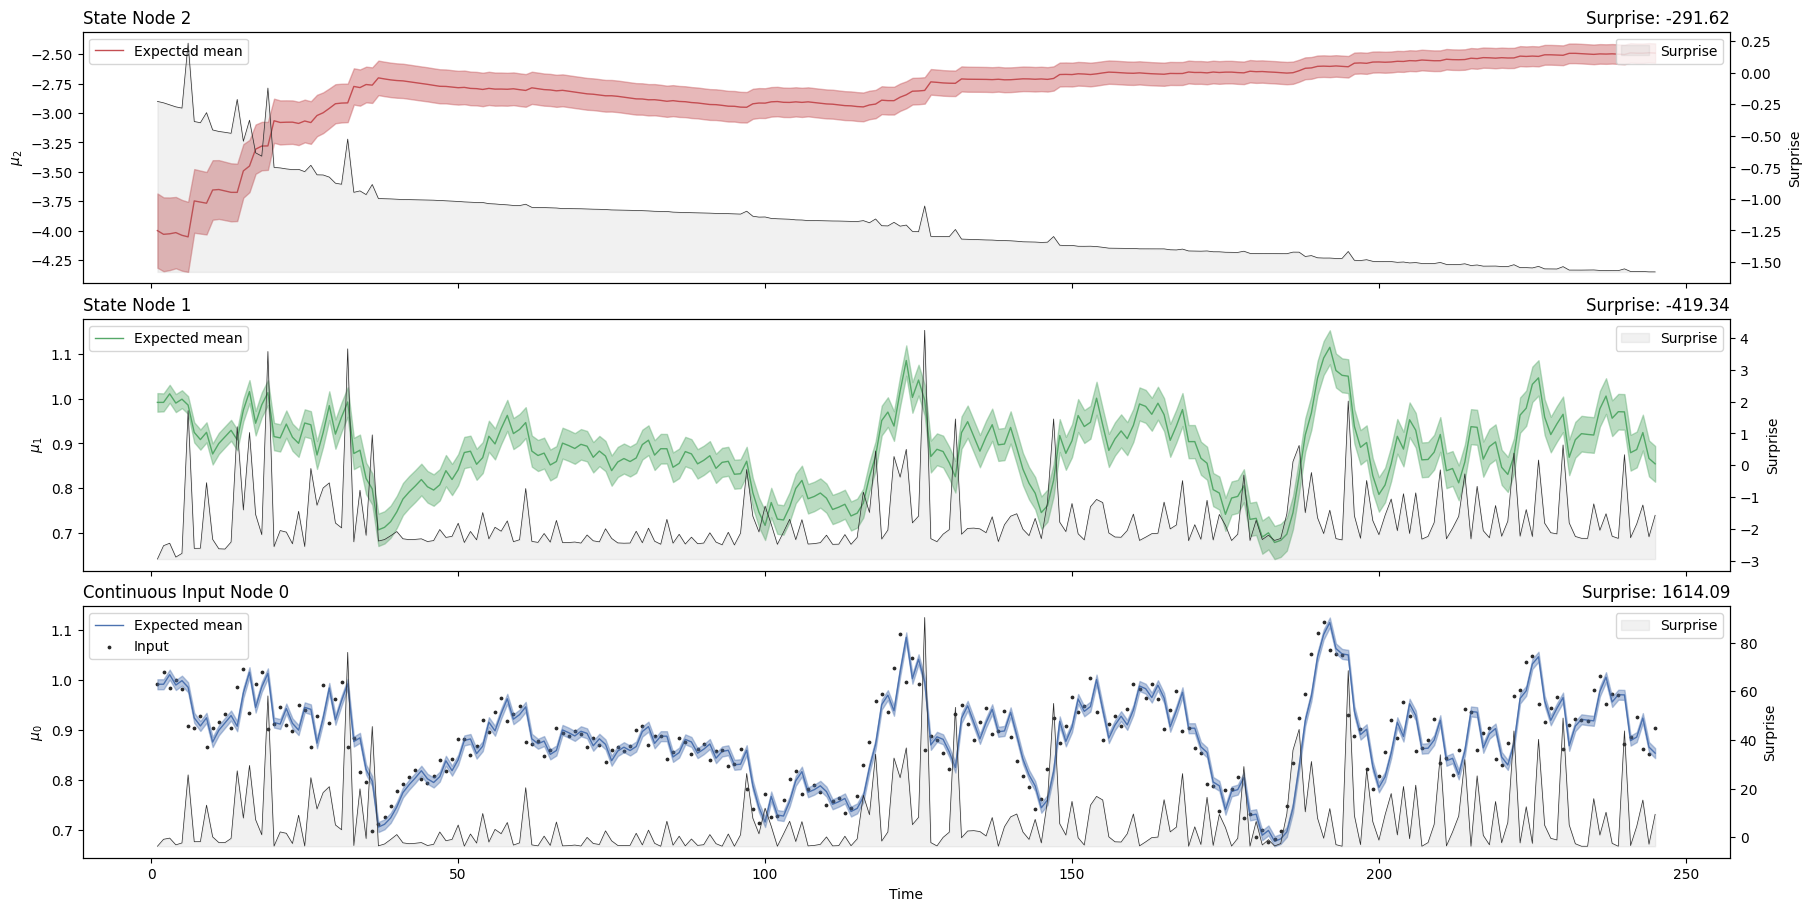

In [11]:
hgf.plot_trajectories();

# System configuration

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Tue Aug 19 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.2.0

pyhgf : 0.2.7
jax   : 0.4.31
jaxlib: 0.4.31

pyhgf     : 0.2.7
matplotlib: 3.10.1
IPython   : 9.2.0
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
pymc      : 5.22.0
numpy     : 2.2.5
pandas    : 2.2.3
arviz     : 0.21.0

Watermark: 2.5.0

